In [1]:
import matplotlib.pyplot as plt

import cv2
import numpy as np
import os
import glob
import pickle
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
vehicles = list(filter(lambda x: not x.startswith('.'), glob.glob('data/vehicles/**/*')))
non_vehicles = list(filter(lambda x: not x.startswith('.'), glob.glob('data/non-vehicles/**/*')))

In [3]:
len(vehicles), len(non_vehicles)

(8792, 8968)

In [4]:
vehicle = load_image(vehicles[0])
non_vehicle = load_image(non_vehicles[0])

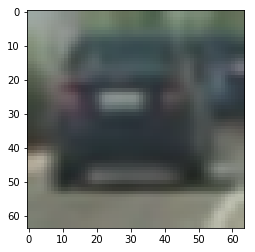

In [5]:
plt.imshow(vehicle)

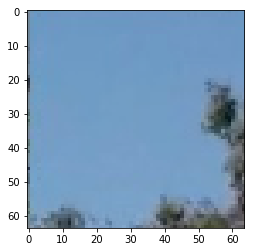

In [6]:
plt.imshow(non_vehicle)

In [7]:
rh, gh, bh, bincen, color_hist_feature_vec = color_hist(vehicle, nbins=32, bins_range=(0, 256))

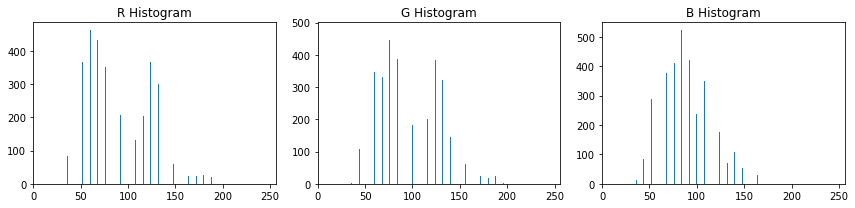

In [8]:
draw_color_histogram(rh, gh, bh, bincen)

In [9]:
scale = max(vehicle.shape[0], vehicle.shape[1], 64) / 64
img_small = cv2.resize(vehicle, (np.int(vehicle.shape[1] / scale), np.int(vehicle.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

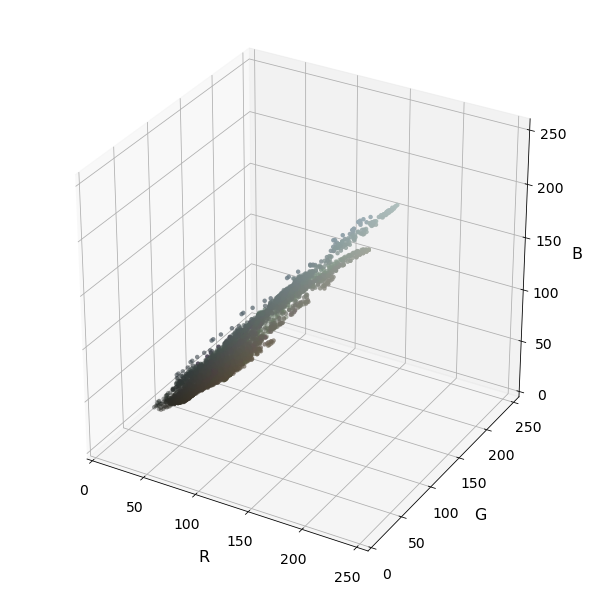

In [10]:
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LAB = cv2.cvtColor(img_small, cv2.COLOR_BGR2LAB)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_Ycr = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

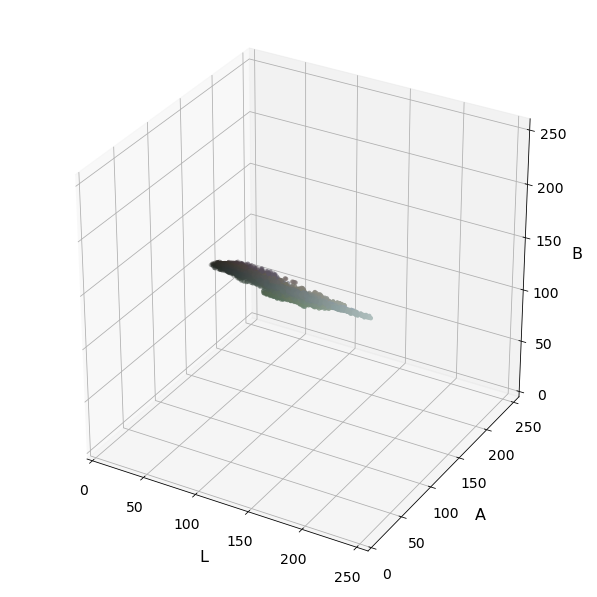

In [11]:
plot3d(img_small_YUV, img_small_rgb, axis_labels=list("LAB"))
plt.show()

In [12]:
color_spatial_feature_vec = bin_spatial(vehicle, color_space='RGB', size=(32, 32))

In [13]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
hog_features, hog_image = get_hog_features(cv2.cvtColor(vehicle, cv2.COLOR_BGR2GRAY), orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

/Users/meshams/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
hog_features.ravel().shape

(1764,)

In [50]:
bin_spatial(vehicle).shape

(3072,)

In [51]:
color_hist(vehicle, 32, feature_vec=True).shape

(96,)

In [53]:
get_hog_features(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY),9,8,2).shape

/Users/meshams/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1764,)

In [15]:
X = extract_features(vehicles + non_vehicles)

/Users/meshams/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [16]:
y = np.concatenate([np.ones(len(vehicles)), np.zeros(len(non_vehicles))])

In [17]:
X.shape, y.shape

((17760, 4932), (17760,))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
scaler = StandardScaler()

In [24]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [47]:
X_train[0].shape

(4932,)

In [25]:
X_train_scaled = scaler.transform(X_train)

In [26]:
X_test_scaled = scaler.transform(X_test)

In [32]:
with open('train.pkl', 'wb') as f:
    pickle.dump({'X': X_train_scaled, 'y': y_train}, f)

In [33]:
with open('test.pkl', 'wb') as f:
    pickle.dump({'X': X_test_scaled, 'y': y_test}, f)

In [148]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [149]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [151]:
clf.score(X_test_scaled, y_test)

0.9953932775976796

In [30]:
from sklearn.externals import joblib

In [154]:
joblib.dump(clf, 'svm.pkl')

['svm.pkl']

In [34]:
clf = joblib.load('svm.pkl')

In [35]:
clf.score(X_test_scaled, y_test)

0.9953932775976796